# <center> Logistic Regression Model

## Load Pacakage.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
import os
from sklearn.model_selection import cross_validate
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load data

In [20]:
file=os.path.dirname(os.getcwd())
Clean_DF = pd.read_csv(file+'\\data\\Steam_Clean_Data.csv')
Train_reco = pd.read_csv(file+'\\data\\Train_reco.csv')
Test_reco = pd.read_csv(file+'\\data\\Test_reco.csv')

## Transform Recomendation Data.

Use tfidvectorizer to transform text data

In [21]:
Tfidf_reco=TfidfVectorizer(
    input="content",
    lowercase=True, 
    stop_words = "english",max_features = 1000)
Train_DTM_reco = Tfidf_reco.fit_transform(Train_reco['review'])
Test_DTM_reco = Tfidf_reco.transform(Test_reco['review'])
DTM_reco=Tfidf_reco.fit_transform(Clean_DF['review'])

Convert tfidvectorizer result to pandas data frame.

In [22]:
Train_DTM_DF_reco=pd.DataFrame(Train_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
Test_DTM_DF_reco=pd.DataFrame(Test_DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())
DTM_DF_reco=pd.DataFrame(DTM_reco.toarray(),columns=Tfidf_reco.get_feature_names())


## Recommendation Model

### Base Model

Set an instantiate logistic model

In [23]:
## Instantiate
log_reco=LogisticRegression(random_state=5)


Use trian data to fit the model.

In [24]:
log_reco.fit(Train_DTM_DF_reco, Train_reco['recommendation'])

LogisticRegression(random_state=5)

Predict the test data

In [25]:
log_pred_reco=log_reco.predict(Test_DTM_DF_reco)

Create a confusion matrix


The confusion matrix is:
[[19211  8410]
 [ 5176 51019]]

The accuracy of logistic regression model is:0.84


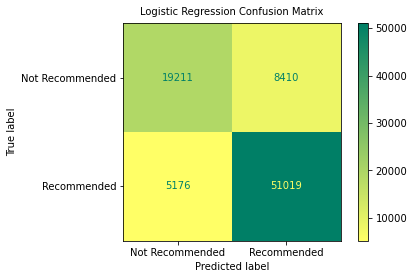

In [26]:
bn_matrix = confusion_matrix(Test_reco['recommendation'], log_pred_reco)
print("\nThe confusion matrix is:")
print(bn_matrix)
plot_confusion_matrix(log_reco, Test_DTM_DF_reco, Test_reco['recommendation'], cmap = 'summer_r')
plt.title("Logistic Regression Confusion Matrix", fontsize = 10, y = 1.01)
print("\nThe accuracy of logistic regression model is:%.2f" % accuracy_score(Test_reco['recommendation'], log_pred_reco))

### Cross Validation

Convert model to integer. 

In [27]:
Label = [1 if Clean_DF.iloc[i,1]=="Recommended" else 0 for i in range(len(Clean_DF))]

Use cross valiadation to generate logistic model.

In [28]:
cv_reco=cross_validate(LogisticRegression(random_state=5), DTM_DF_reco, Label, cv=6,
                        scoring = ['accuracy','precision','f1'], return_estimator =True)

Print accuracy score

In [29]:
print("The averege accuracy of cross validation is %.2f" % cv_reco['test_accuracy'].mean())
print("The averege precision of cross validation is %.2f" % cv_reco['test_precision'].mean())
print("The averege f1 of cross validation is %.2f" % cv_reco['test_f1'].mean())

The averege accuracy of cross validation is 0.82
The averege precision of cross validation is 0.85
The averege f1 of cross validation is 0.87


## Feature Importance

Create the feature importance for each cross validation.

In [30]:
def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot 
    #plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right',fontsize=20)
    #plt.show()

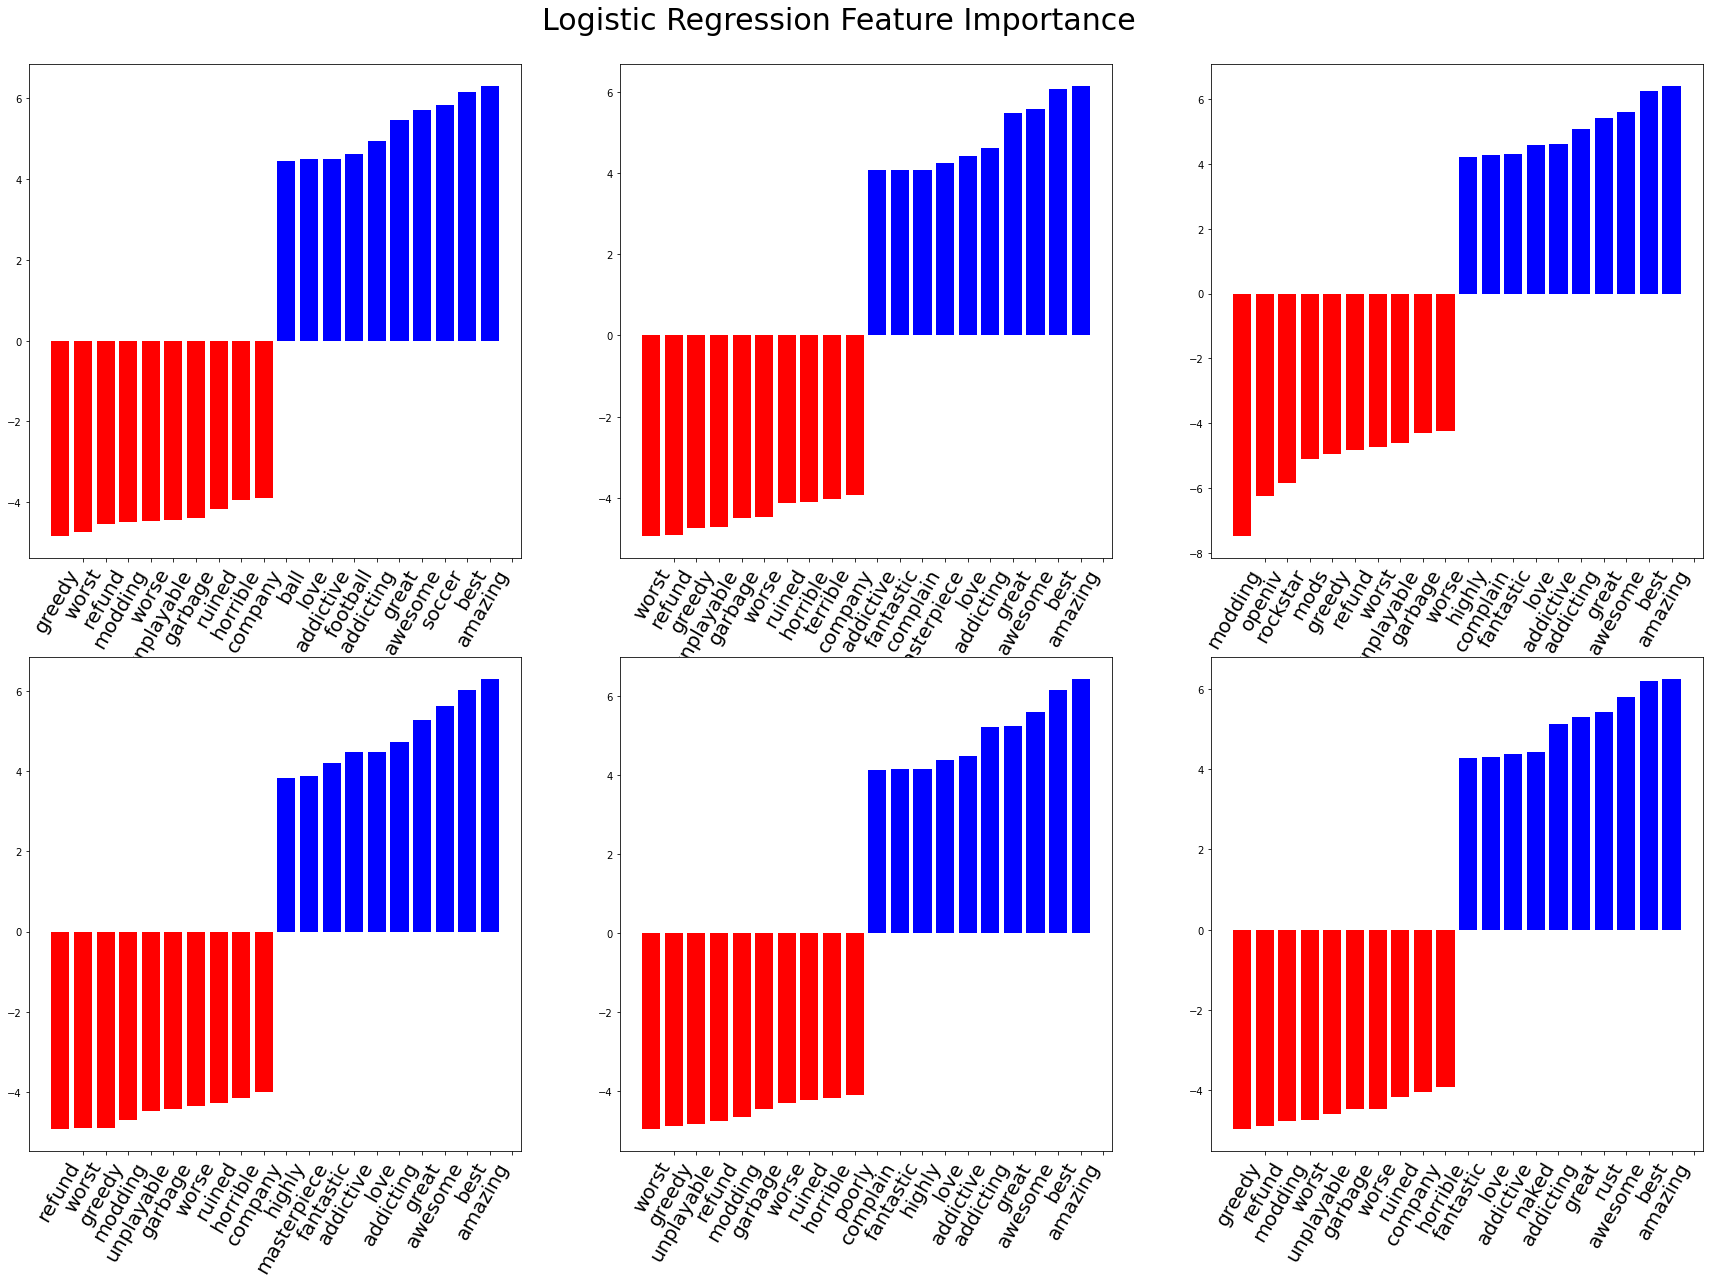

In [31]:
fig=plt.figure(figsize=(30,20))

for idx,estimator in enumerate(cv_reco['estimator']):
    plt.suptitle("Logistic Regression Feature Importance", fontsize = 30, y = 0.92)
    #print("Features sorted by their score for estimator {}:".format(idx))
    """feature_importances = pd.DataFrame(estimator.coef_.T,
                                       index = Train_cv_DF.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)"""
    #print(feature_importances[:10:])
    plt.subplot(231+idx)
    plot_coefficients(estimator, Train_DTM_DF_reco.columns, 10)
    #plt.bar(x = feature_importances.index[:10:], height=feature_importances["importance"][:10:])

## Save model and vectorize to local


In [32]:
pickle.dump(log_reco, open('log_model.pkl', 'wb'))
pickle.dump(Tfidf_reco, open("Tfidf_reco.pkl", "wb"))